# LoRA Analysis with SVD on ViT Models

## 🧩 LoRA 正交性与子空间分析 / LoRA Orthogonality and Subspace Analysis

**Setup（设置）**

Given a pre-trained weight $W_0$ and a LoRA update $\Delta W$,  
we analyze the alignment between $W_0$ and $\Delta W$ via subspace projections.  
We compute the SVDs:
$$
\Delta W = U_{\Delta} \Sigma_{\Delta} V_{\Delta}^{\top}, \qquad
W_0 = U_W \Sigma_W V_W^{\top}.
$$

---

**Projection on $\Delta W$ subspace（投影到 $\Delta W$ 子空间）**

The normalized Frobenius energy of $W_0$ in the $\Delta W$-subspace is:
$$
E_{\Delta} = \frac{\|U_{\Delta}^{\top} W_0 V_{\Delta}^{\top}\|_F}{\|W_0\|_F}.
$$

---

**Projection on top-$r$ subspace of $W_0$（投影到 $W_0$ 的前 $r$ 奇异子空间）**

$$
E_{W, r} = \frac{\|\,(U_W^{(r)})^{\top} W_0 (V_W^{(r)})^{\top}\|_F}{\|W_0\|_F}.
$$

---

**Relative alignment ratio（相对对齐比）**

$$
\rho = \frac{\|U_{\Delta}^{\top} W_0 V_{\Delta}^{\top}\|_F}
             {\|(U_W^{(r)})^{\top} W_0 (V_W^{(r)})^{\top}\|_F}.
$$

---

**Interpretation（结论解读）**

Empirically, $E_{\Delta}$ is near zero (e.g., 0.02–0.16),  
while $E_{W,r}$ is much larger (e.g., 0.4–0.8), and $\rho \ll 1$.  
This supports the LoRA orthogonality hypothesis:  
$\Delta W$ tends to occupy task-specific directions largely disjoint  
from the dominant subspace of $W_0$.


In [ ]:
# Load model directly
import os
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-large-patch16-224-in21k", use_fast=True)
model = AutoModelForImageClassification.from_pretrained("google/vit-large-patch16-224-in21k", use_auth_token=os.environ['HF_TOKEN'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.classifier = torch.nn.Linear(model.config.hidden_size, 1000)  # ImageNet 有 1000 个类别
model.config.num_labels = 1000 

from peft import LoraConfig, get_peft_model, TaskType

target_modules = ['query', 'value']


lora_config = LoraConfig(
    # 分类任务类型
    task_type=TaskType.FEATURE_EXTRACTION, # 或 TaskType.IMAGE_CLASSIFICATION (取决于 PEFT 版本)
    r=16,          # LoRA 秩 (Rank): 决定引入的参数量和表达能力
    lora_alpha=32, # 缩放因子 (通常设为 r 的两倍或相等)
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none"
)


model_peft = get_peft_model(model, lora_config)
model_peft.to(device)

print(f"--- LoRA Model Summary ---")
model_peft.print_trainable_parameters() 

/root/miniconda3/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- LoRA Model Summary ---
trainable params: 1,572,864 || all params: 305,899,496 || trainable%: 0.5142


## LoRA 微调后的模型权重 SVD 分析

In [5]:
# 加载训练好的权重
from peft import PeftModel

lora_model = PeftModel.from_pretrained(model, "./vit_lora_imagenet_model", is_trainable=False)

/root/miniconda3/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [6]:
import matplotlib.pyplot as plt
import numpy as np

NUM_LAYERS = len(lora_model.vit.encoder.layer)

# 初始化存储结果的字典
singular_values_data = {
    'Q': [None] * NUM_LAYERS,
    'V': [None] * NUM_LAYERS
}



def analyze_lora_update(lora_model):
    """提取每层 W_Q 和 W_V 的 LoRA 更新矩阵，并计算 SVD。"""
    
    for layer_idx in range(NUM_LAYERS):
        print(f"--- 正在分析 Layer {layer_idx} ---")
        
        # 假设 ViT 结构：vit.encoder.layer[idx].attention.attention
        attn_layer = lora_model.vit.encoder.layer[layer_idx].attention.attention
        
        # 遍历 Query 和 Value 矩阵
        for matrix_type in ['Q', 'V']:
            if matrix_type == 'Q':
                lora_module = attn_layer.query
            else:
                lora_module = attn_layer.value
            
            # --- 1. 提取 A 和 B 矩阵 ---
            # 假设 LoRA 模块名称为 'default' (PEFT 默认)
            try:
                A = lora_module.lora_A['default'].weight.data
                B = lora_module.lora_B['default'].weight.data
            except AttributeError:
                print(f"警告: Layer {layer_idx}, {matrix_type} 矩阵未找到 LoRA 权重。跳过。")
                continue
            
            # --- 2. 计算 Delta W (LoRA 更新矩阵) ---
            # 确保矩阵乘法顺序正确：B @ A (d_out x r) @ (r x d_in) = d_out x d_in
            # 注意：如果你的 A, B 是 (d_in x r) 和 (r x d_out) 形式，请使用 A @ B。
            # 通常在 PyTorch Linear层中，weight是转置的，这里的 B@A 假设 A, B 已经被正确提取。
            Delta_W = B @ A
            
            # --- 3. 执行 SVD ---
            # full_matrices=False 返回一个紧凑的 SVD 结果
            # S 是奇异值 (从大到小排序)
            try:
                _, S, _ = torch.linalg.svd(Delta_W, full_matrices=False)
                
                # SVD 结果是 torch.Tensor，转换为 NumPy for plotting
                singular_values_data[matrix_type][layer_idx] = S.cpu().numpy()
            except Exception as e:
                print(f"SVD 计算失败在 Layer {layer_idx}, {matrix_type}: {e}")

    return singular_values_data

# 执行分析
results = analyze_lora_update(lora_model)

--- 正在分析 Layer 0 ---
--- 正在分析 Layer 1 ---
--- 正在分析 Layer 2 ---
--- 正在分析 Layer 3 ---
--- 正在分析 Layer 4 ---
--- 正在分析 Layer 5 ---
--- 正在分析 Layer 6 ---
--- 正在分析 Layer 7 ---
--- 正在分析 Layer 8 ---
--- 正在分析 Layer 9 ---
--- 正在分析 Layer 10 ---
--- 正在分析 Layer 11 ---
--- 正在分析 Layer 12 ---
--- 正在分析 Layer 13 ---
--- 正在分析 Layer 14 ---
--- 正在分析 Layer 15 ---
--- 正在分析 Layer 16 ---
--- 正在分析 Layer 17 ---
--- 正在分析 Layer 18 ---
--- 正在分析 Layer 19 ---
--- 正在分析 Layer 20 ---
--- 正在分析 Layer 21 ---
--- 正在分析 Layer 22 ---
--- 正在分析 Layer 23 ---


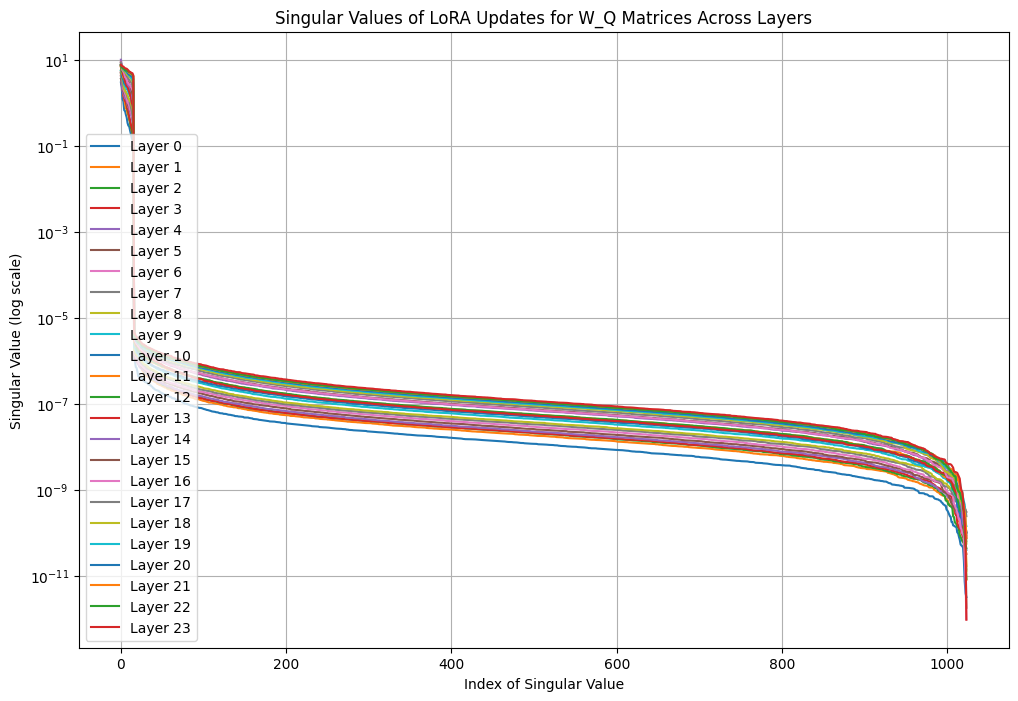

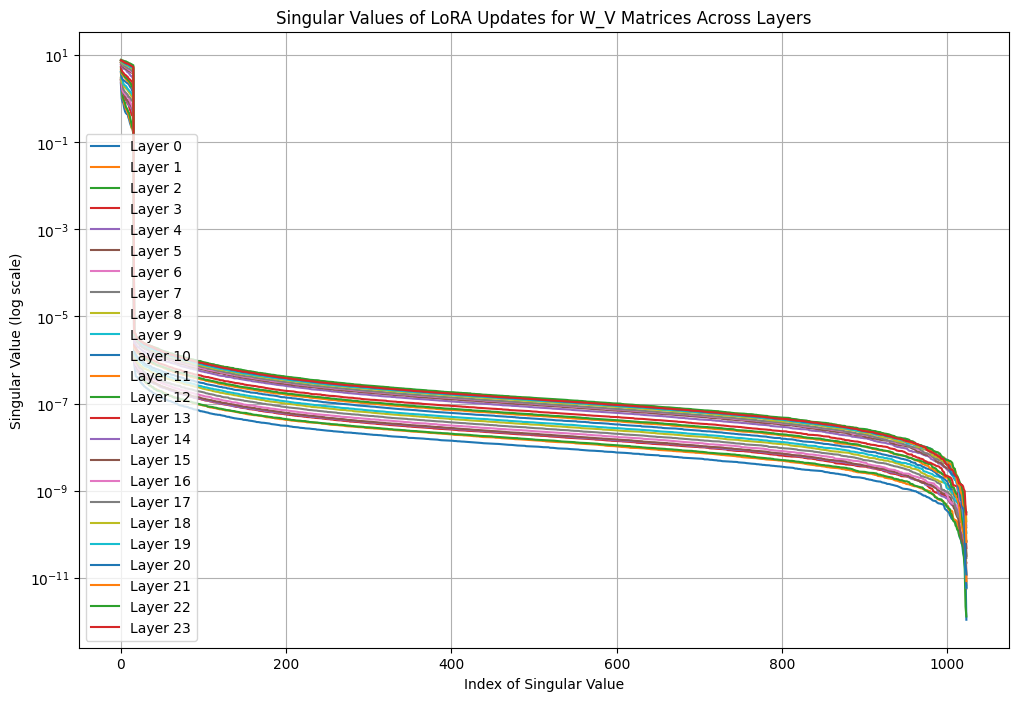

In [7]:
# show results
def plot_singular_values(singular_values_data, matrix_type):
    """绘制每层的奇异值分布。"""
    plt.figure(figsize=(12, 8))
    
    for layer_idx, singular_values in enumerate(singular_values_data[matrix_type]):
        if singular_values is not None:
            plt.plot(singular_values, label=f'Layer {layer_idx}')
    
    plt.yscale('log')
    plt.title(f'Singular Values of LoRA Updates for W_{matrix_type} Matrices Across Layers')
    plt.xlabel('Index of Singular Value')
    plt.ylabel('Singular Value (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# 绘制 W_Q 和 W_V 的奇异值分布
plot_singular_values(results, 'Q')
plot_singular_values(results, 'V')

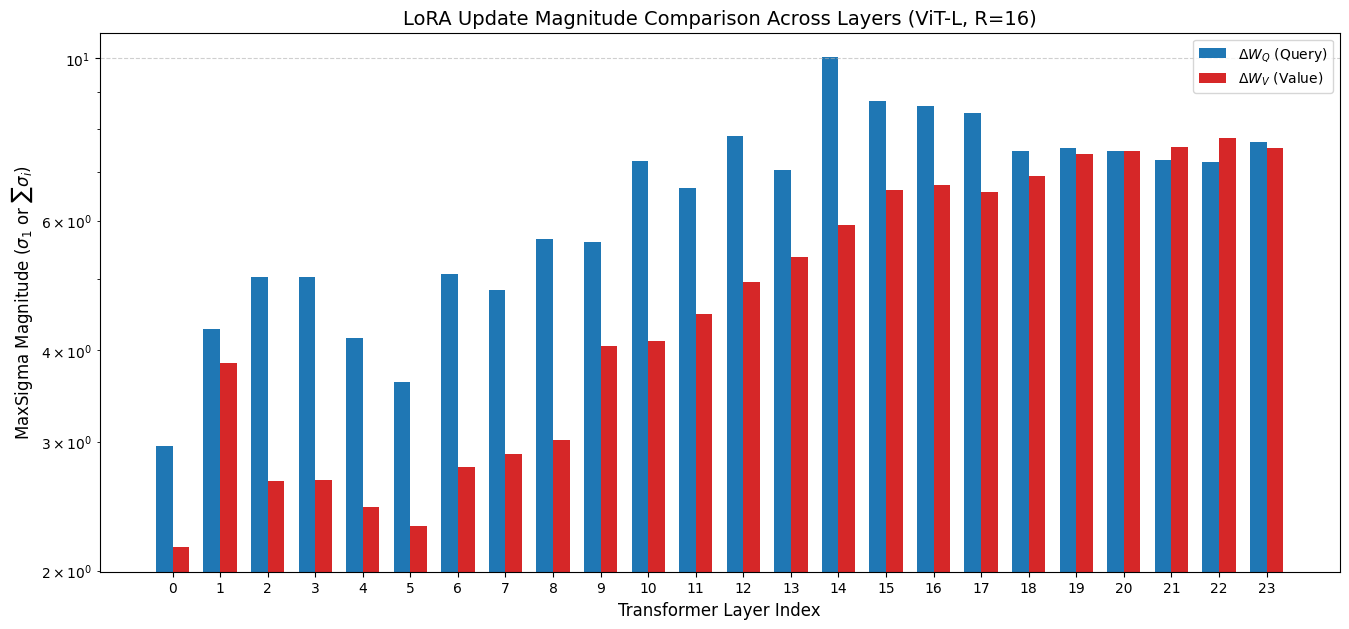

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

LORAR = lora_config.r

# 假设 results 字典已经包含 W_Q 和 W_V 的奇异值
# LORAR = 16 # 你使用的秩
# NUM_LAYERS = 24 # ViT-Large 的层数

def plot_lora_analysis_bar_chart(results, mode='MaxSigma'):
    """
    绘制 W_Q 和 W_V 奇异值的柱状图对比，用于分析工作负载分配。
    mode: 'MaxSigma' (最大奇异值) 或 'EnergySum' (前 r 个奇异值之和)
    """
    
    q_values = []
    v_values = []

    for layer_idx in range(NUM_LAYERS):
        sv_q = results['Q'][layer_idx]
        sv_v = results['V'][layer_idx]
        
        if sv_q is None or sv_v is None:
            q_values.append(0)
            v_values.append(0)
            continue
            
        if mode == 'MaxSigma':
            # 方法一：使用最大奇异值 (sigma_1，即索引 0 处的值) 作为更新强度的代表
            q_values.append(sv_q[0])
            v_values.append(sv_v[0])
            
        elif mode == 'EnergySum':
            # 方法二：使用前 r 个奇异值的和
            r = LORAR # 使用全局定义的 LORAR
            q_values.append(np.sum(sv_q[:r]))
            v_values.append(np.sum(sv_v[:r]))

    # --- 绘图 ---
    layers = np.arange(NUM_LAYERS)
    width = 0.35  # 柱状图宽度

    fig, ax = plt.subplots(figsize=(16, 7))
    
    # 核心修改点：使用 r'' 原始字符串
    rects_q = ax.bar(layers - width/2, q_values, width, label=r'$\Delta W_Q$ (Query)', color='tab:blue')
    rects_v = ax.bar(layers + width/2, v_values, width, label=r'$\Delta W_V$ (Value)', color='tab:red')

    # 设置图表标签和标题
    # 核心修改点：使用 r'' 原始字符串
    ylabel_text = r'{} Magnitude ($\sigma_1$ or $\sum \sigma_i$)'.format(mode)
    ax.set_ylabel(ylabel_text, fontsize=12)
    
    ax.set_xlabel('Transformer Layer Index', fontsize=12)
    ax.set_title(r'LoRA Update Magnitude Comparison Across Layers (ViT-L, R={})'.format(LORAR), fontsize=14)
    ax.set_xticks(layers)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # 将 y 轴设置为对数尺度
    ax.set_yscale('log')
    
    plt.show()

# 绘制柱状图对比
plot_lora_analysis_bar_chart(singular_values_data, mode='MaxSigma')

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def project_norm_ratio(W: torch.Tensor, dW: torch.Tensor, r: int = 8):
    """Compute ||U_dW^T W V_dW||_F / ||W||_F for ΔW subspace, W-topr, and random."""
    W = W.detach().cpu()
    dW = dW.detach().cpu()

    # === SVD decomposition ===
    U_dW, S_dW, Vh_dW = torch.linalg.svd(dW, full_matrices=False)
    U_W, S_W, Vh_W = torch.linalg.svd(W, full_matrices=False)

    # Top-r subspaces
    U_dW_r, V_dW_r = U_dW[:, :r], Vh_dW[:r, :].T
    U_W_r, V_W_r = U_W[:, :r], Vh_W[:r, :].T

    # Random orthogonal
    randU, _ = torch.linalg.qr(torch.randn_like(U_dW_r))
    randV, _ = torch.linalg.qr(torch.randn_like(V_dW_r))

    def frob_ratio(U, V):
        proj = U.T @ W @ V
        return torch.norm(proj, "fro") / torch.norm(W, "fro")

    ratio_delta = frob_ratio(U_dW_r, V_dW_r).item()
    ratio_W = frob_ratio(U_W_r, V_W_r).item()
    ratio_rand = frob_ratio(randU, randV).item()

    return ratio_delta, ratio_W, ratio_rand


def extract_lora_weights(module):
    """安全地提取 lora_A, lora_B 权重"""
    if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
        A = module.lora_A
        B = module.lora_B
        # 若为 ModuleDict，则取 default 分支
        if isinstance(A, torch.nn.ModuleDict):
            A = A["default"]
            B = B["default"]
        return A.weight, B.weight
    return None, None


def analyze_all_lora_layers(model, rank=8):
    results = []
    for name, module in model.named_modules():
        A, B = extract_lora_weights(module)
        if A is not None and B is not None and hasattr(module, "weight"):
            dW = B @ A
            W = module.weight

            try:
                ratio_delta, ratio_W, ratio_rand = project_norm_ratio(W, dW, r=rank)
                results.append({
                    "Layer": name,
                    "ΔW-subspace": ratio_delta,
                    "W-topr": ratio_W,
                    "Random": ratio_rand,
                    "ΔW/F(W)": torch.norm(dW, "fro").item() / torch.norm(W, "fro").item()
                })
            except RuntimeError as e:
                print(f"⚠️ 跳过 {name} （SVD计算失败）: {e}")
    df = pd.DataFrame(results)
    return df


# ==== 执行分析 ====
df = analyze_all_lora_layers(model_peft, rank=16)

# ==== 输出表格 ====
pd.set_option('display.max_rows', None)
print(df.round(4))


                                                Layer  ΔW-subspace  W-topr  \
0   base_model.model.vit.encoder.layer.0.attention...       0.1625  0.7645   
1   base_model.model.vit.encoder.layer.0.attention...       0.0453  0.4856   
2   base_model.model.vit.encoder.layer.1.attention...       0.1447  0.7286   
3   base_model.model.vit.encoder.layer.1.attention...       0.0482  0.4483   
4   base_model.model.vit.encoder.layer.2.attention...       0.1345  0.6815   
5   base_model.model.vit.encoder.layer.2.attention...       0.0487  0.4643   
6   base_model.model.vit.encoder.layer.3.attention...       0.0898  0.6269   
7   base_model.model.vit.encoder.layer.3.attention...       0.0448  0.4758   
8   base_model.model.vit.encoder.layer.4.attention...       0.0721  0.5692   
9   base_model.model.vit.encoder.layer.4.attention...       0.0361  0.4690   
10  base_model.model.vit.encoder.layer.5.attention...       0.0711  0.5773   
11  base_model.model.vit.encoder.layer.5.attention...       0.04

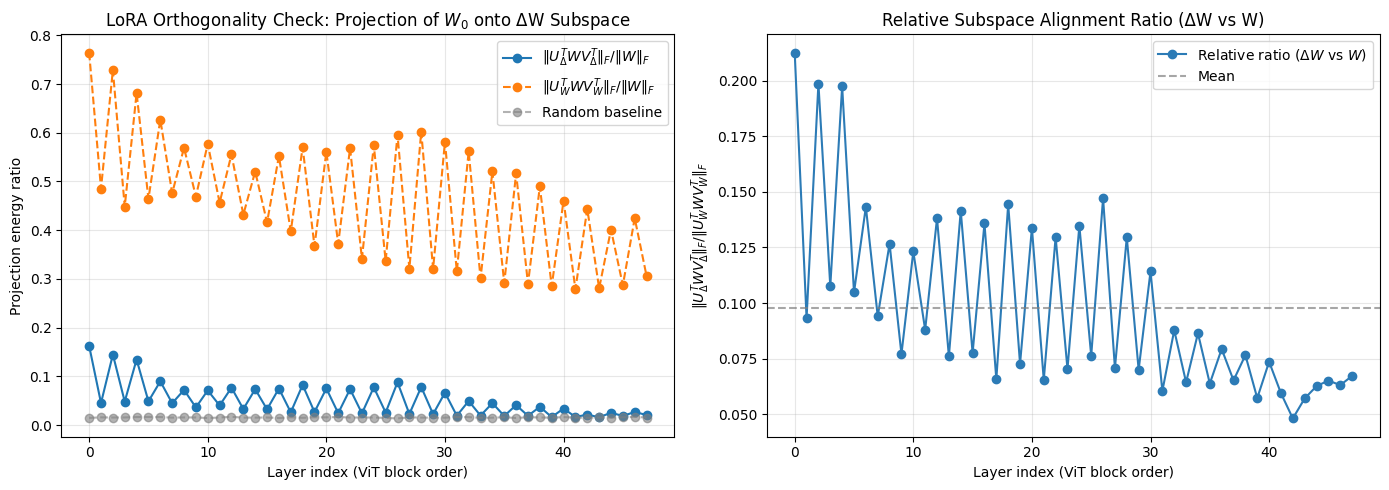

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ======== 数据准备 ========
layers = np.arange(len(df))
dw_sub = df["ΔW-subspace"]
w_topr = df["W-topr"]
rand = df["Random"]
ratio = dw_sub / w_topr

# ======== 可视化 ========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 左图: 正交性趋势 ---
axes[0].plot(layers, dw_sub, 'o-', color='#1f77b4', label=r"$\|U_\Delta^T W V_\Delta^T\|_F / \|W\|_F$")
axes[0].plot(layers, w_topr, 'o--', color='#ff7f0e', label=r"$\|U_W^T W V_W^T\|_F / \|W\|_F$")
axes[0].plot(layers, rand, 'o--', color='gray', alpha=0.6, label="Random baseline")

axes[0].set_title("LoRA Orthogonality Check: Projection of $W_0$ onto ΔW Subspace")
axes[0].set_xlabel("Layer index (ViT block order)")
axes[0].set_ylabel("Projection energy ratio")
axes[0].grid(alpha=0.3)
axes[0].legend()

# --- 右图: 相对对齐比 ---
axes[1].plot(layers, ratio, 'o-', color='#2C7BB6', label=r"Relative ratio ($ΔW$ vs $W$)")
axes[1].axhline(y=np.mean(ratio), color='gray', linestyle='--', alpha=0.7, label="Mean")
axes[1].set_title("Relative Subspace Alignment Ratio (ΔW vs W)")
axes[1].set_xlabel("Layer index (ViT block order)")
axes[1].set_ylabel(r"$\|U_\Delta^T W V_\Delta^T\|_F / \|U_W^T W V_W^T\|_F$")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()



---

## 🧩 LoRA Orthogonality and Subspace Analysis

To further investigate the relationship between the pre-trained weights $W_0$ and the LoRA-induced update $\Delta W$,
we analyze the projection of $W_0$ onto the subspace spanned by the singular vectors of $\Delta W$.
Formally, we compute the normalized Frobenius energy:

$$
\frac{|U_{\Delta}^{\top} W_0 V_{\Delta}^{\top}|_F}{|W_0|_F}
$$

where $U_{\Delta}$ and $V_{\Delta}$ denote the left and right singular-vector matrices of $\Delta W$.
This quantity measures how much of the pre-trained weight energy lies within the subspace of the LoRA update.

---

### **Results and Observations**

As shown in *Figure X (left)*,
the projection energy of $W_0$ onto the $\Delta W$ subspace remains extremely low across all ViT transformer blocks,
ranging from **0.02 to 0.16**.
In contrast, the energy of $W_0$ projected onto its own dominant subspace ($U_W$, $V_W$) remains high (**0.4–0.8**).
The random baseline stays near zero, confirming that the low projection values are not due to noise.

We also compute the relative alignment ratio:

$$
\rho = \frac{|U_{\Delta}^{\top} W_0 V_{\Delta}^{\top}|_F}{|U_W^{\top} W_0 V_W^{\top}|_F}
$$

illustrated in *Figure X (right)*.
The ratio remains consistently **below 0.2**, indicating that $\Delta W$ is almost orthogonal to the dominant directions of $W_0$.

---

### **Interpretation**

These results strongly support the **LoRA orthogonality hypothesis** (Hu et al., 2021):

> *The low-rank adaptation updates $\Delta W$ occupy new, task-specific directions that are largely disjoint from the pre-trained weight subspace.*

In other words:

* $\Delta W$ contributes novel representational capacity without overwriting the general knowledge encoded in $W_0$;
* Fine-tuning with LoRA effectively decouples **task adaptation** from **core model knowledge**,
  leading to stable and efficient parameter-efficient transfer learning.

---

### ✅ **Summary**

| Observation                    | Description                                                                         |
| ------------------------------ | ----------------------------------------------------------------------------------- |
| $\Delta W$ Subspace Projection | 0.02–0.16 (very low)                                                                |
| $W$-Top Subspace Projection    | 0.4–0.8 (dominant energy)                                                           |
| Relative Alignment $\rho$      | < 0.2                                                                               |
| Conclusion                     | $\Delta W$ and $W_0$ are nearly orthogonal — LoRA learns new task-specific subspace |

---



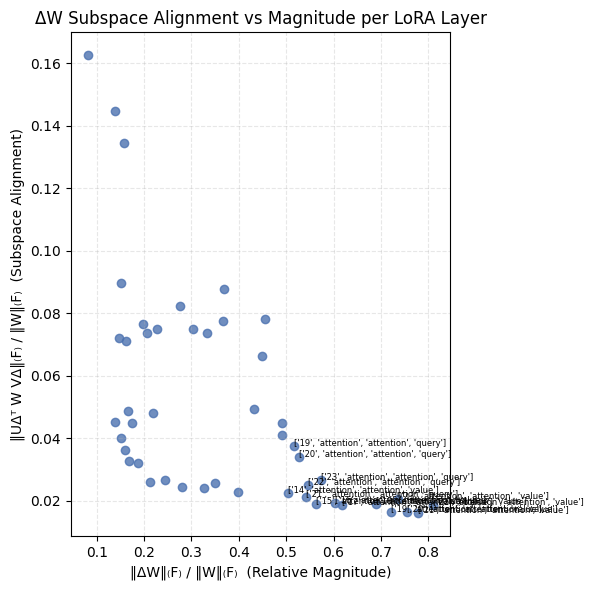

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(df["ΔW/F(W)"], df["ΔW-subspace"], color="#4C72B0", alpha=0.8)
for i, row in df.iterrows():
    if row["ΔW-subspace"] > 0.6 or row["ΔW/F(W)"] > 0.5:
        plt.text(row["ΔW/F(W)"], row["ΔW-subspace"], row["Layer"].split(".")[-4:], fontsize=6)
plt.xlabel("‖ΔW‖₍F₎ / ‖W‖₍F₎  (Relative Magnitude)")
plt.ylabel("‖UΔᵀ W VΔ‖₍F₎ / ‖W‖₍F₎  (Subspace Alignment)")
plt.title("ΔW Subspace Alignment vs Magnitude per LoRA Layer")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


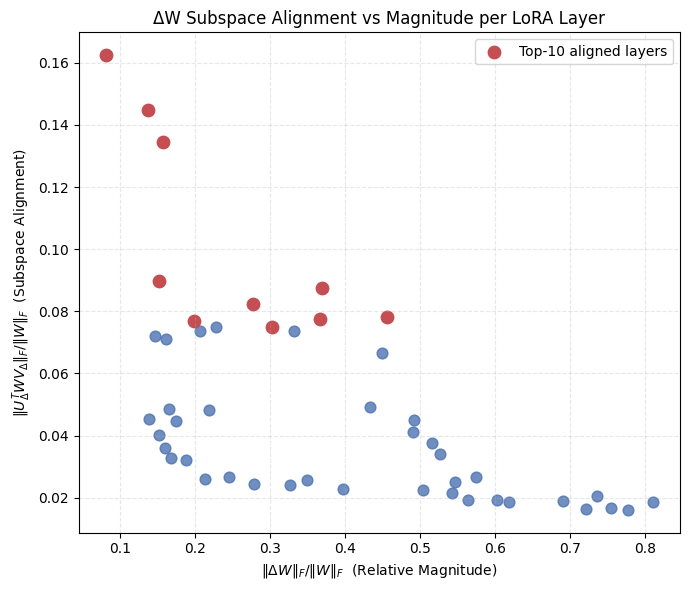

In [13]:
plt.figure(figsize=(7, 6))
plt.scatter(df["ΔW/F(W)"], df["ΔW-subspace"], color="#4C72B0", alpha=0.8, s=60)

# 高亮前 10 层
top = df.sort_values("ΔW-subspace", ascending=False).head(10)
plt.scatter(top["ΔW/F(W)"], top["ΔW-subspace"], color="#C44E52", s=80, label="Top-10 aligned layers")

plt.xlabel(r"$\| \Delta W \|_F / \| W \|_F$  (Relative Magnitude)")
plt.ylabel(r"$\| U_{\Delta}^T W V_{\Delta} \|_F / \| W \|_F$  (Subspace Alignment)")
plt.title("ΔW Subspace Alignment vs Magnitude per LoRA Layer")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
